<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!ls "drive/My Drive/dataset/Long_words/"

Read_me.txt			      sub_6_ch64_l_eog_removed_256Hz.mat
sub_11b_ch64_l_eog_removed_256Hz.mat  sub_7_ch64_l_eog_removed_256Hz.mat
sub_2b_ch64_l_eog_removed_256Hz.mat   sub_9c_ch64_l_eog_removed_256Hz.mat


In [11]:

mat = scipy.io.loadmat("drive/My Drive/dataset/Long_words/sub_2b_ch64_l_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [17]:
print(end_trial[0][0])

[[  2.0756692    3.3451948    1.2805819  ...   1.03499391  -1.8243698
   -1.01871216]
 [ -3.82600849 -11.7789427  -19.90806902 ...  12.53093915   8.48127123
   11.22360224]
 [ -3.00310901  -5.53589825 -10.7160167  ...   8.79775373   5.17229481
    8.20442485]
 ...
 [ -3.28631204 -12.27128688 -21.85336011 ...   7.17226805   4.4037043
    6.18084104]
 [ -1.91263385  -4.37623631  -7.82609212 ...   1.17744386  -3.16380532
    0.43488985]
 [  2.51450495   6.26755729   2.75070428 ...   1.19598115  -4.54512732
   -1.76451922]]


In [18]:
print(end_trial[1][0])

[[ -1.27735546  -3.82002997  -2.88641743 ...   1.9763067    2.05661518
    1.3593881 ]
 [ -4.90701477  -8.48444293  -5.82129236 ...  -2.30271976  -0.36951821
    1.3378214 ]
 [ -5.40068243  -9.89625475  -7.20670153 ...  -1.60120045   0.36174521
    4.19075407]
 ...
 [ -5.3620891   -9.69451373  -6.31911269 ...  -3.00807071   0.27529782
    2.78197364]
 [ -6.75004416 -11.84629843  -7.65657429 ...  -0.45278445   0.70701181
    1.51307907]
 [ -6.31367576  -8.92761731  -4.09098874 ...   7.03288896   4.97767805
    3.63721799]]


# Cooperate in resting state

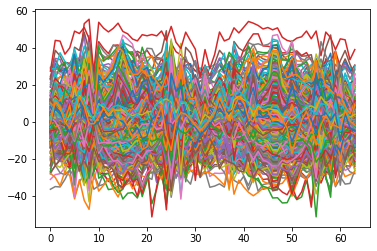

In [19]:
plt.plot(end_trial[0][0]);

# Cooperate during speech imagery state

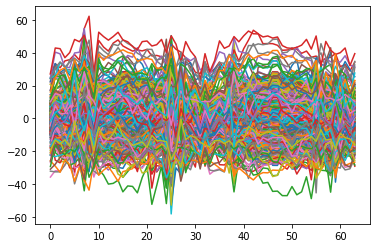

In [20]:
plt.plot(last_beep[0][0]);

# Independent during resting state

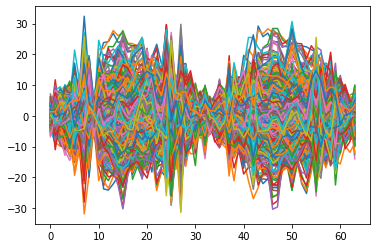

In [21]:
plt.plot(end_trial[1][0]);

# Independent during speech imagery state

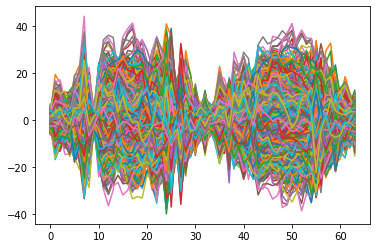

In [22]:
plt.plot(last_beep[1][0]);

#Covariance Matrix Calculation

In [23]:
def covariance(matrix):
  res_mat = np.matmul(matrix,matrix.transpose())
  return res_mat

#Load Matrices:
Here we load matrices for both classes from all files in the directory.

In [24]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)


In [25]:
x_train = loadMatrices("drive/My Drive/dataset/Long_words/")

In [26]:
print(x_train.shape)

(2000, 64, 64)


In [27]:
y_train = np.concatenate((np.zeros(1000),np.ones(1000)),axis=0)
print(y_train.shape)

(2000,)


In [28]:
print(y_train)

[0. 0. 0. ... 1. 1. 1.]


In [65]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten;

model=Sequential()

model.add(Conv2D(64, kernel_size=2, activation="relu" , input_shape=(64,64,1)))

model.add(Conv2D(64, kernel_size=4, activation="relu", input_shape=(64,64,1)))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='relu'))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 63, 63, 64)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        65600     
_________________________________________________________________
dense_4 (Dense)              (None, 60, 60, 128)       8320      
_________________________________________________________________
dense_5 (Dense)              (None, 60, 60, 128)       16512     
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 921602    
Total params: 1,012,354
Trainable params: 1,012,354
Non-trainable params: 0
____________________________________________

In [66]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(y_train)
print(x_train)

[1. 1. 0. ... 0. 1. 0.]
[[[ 8.70412004e+03 -2.35039398e+03  5.66592140e+02 ... -1.91633388e+03
   -1.72680670e+03  2.21447607e+03]
  [-2.35039398e+03  2.49037582e+04  1.92026526e+04 ...  2.46928043e+04
    1.29113897e+04  5.35032013e+03]
  [ 5.66592140e+02  1.92026526e+04  1.86547779e+04 ...  1.91212327e+04
    9.42523164e+03  7.72201131e+03]
  ...
  [-1.91633388e+03  2.46928043e+04  1.91212327e+04 ...  2.79559756e+04
    1.49476773e+04  6.12496743e+03]
  [-1.72680670e+03  1.29113897e+04  9.42523164e+03 ...  1.49476773e+04
    1.15873093e+04  3.66367875e+03]
  [ 2.21447607e+03  5.35032013e+03  7.72201131e+03 ...  6.12496743e+03
    3.66367875e+03  1.23938845e+04]]

 [[ 4.96178133e+03  7.22950823e+02  2.91048404e+03 ... -1.24665442e+03
   -2.14124222e+02  3.56973820e+03]
  [ 7.22950823e+02  2.73843998e+04  1.64842342e+04 ...  2.42233064e+04
    8.86450495e+03  5.27157756e+03]
  [ 2.91048404e+03  1.64842342e+04  1.90037008e+04 ...  1.47997056e+04
    6.52829696e+03  8.26512150e+03]
  ...

In [67]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [68]:
divide_percent=(len(x_train)/20)
x_test=x_train[0:int(divide_percent)]
y_test=y_train[0:int(divide_percent)]

In [69]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)

Epoch 1/100


ValueError: ignored